In [1]:
#importing libraries
import itertools
import pandas as pd
import numpy as np

from  datetime import datetime, timedelta
import gc, copy

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import lightgbm as lgb

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
#reading training data
df_train = pd.read_csv('C:/Users/HP/Desktop/av4/train.csv')

In [3]:
df_train.head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [4]:
#reading test data
df_test = pd.read_csv('C:/Users/HP/Desktop/av4/test.csv')

In [5]:
df_test.head()

,date,hour
0,2021-03-01,0
1,2021-03-01,1
2,2021-03-01,2
3,2021-03-01,3
4,2021-03-01,5


<AxesSubplot:xlabel='date'>

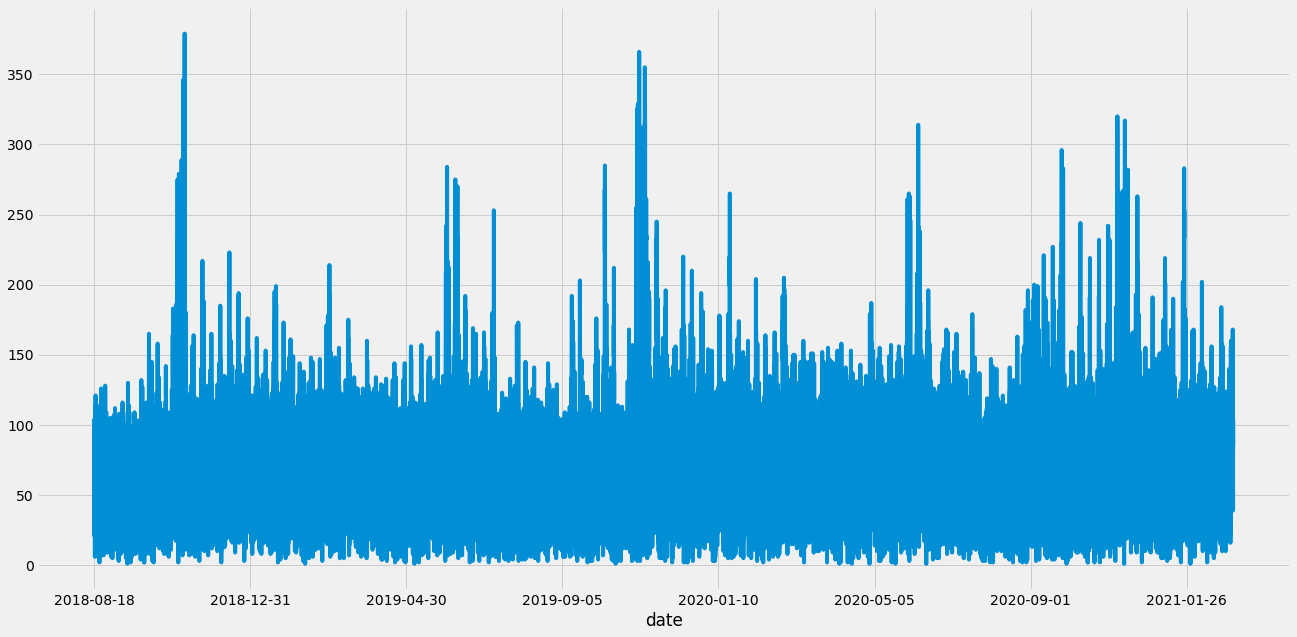

In [6]:
# taking a quick look at given data
plt.figure(figsize=(20,10))
df_train.set_index('date').demand.plot()

In [7]:
# Extracting important features from given dataset

In [8]:
df_train['date'] = pd.to_datetime(df_train["date"])

In [9]:
date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",

    }

In [10]:
for date_feat_name, date_feat_func in date_features.items():
    if date_feat_name in df_train.columns:
        df_train[date_feat_name] = df_train[date_feat_name].astype("int16")
    else:
        df_train[date_feat_name] = getattr(df_train["date"].dt, date_feat_func).astype("int16")

In [11]:
df_train["is_wknd"] = df_train.date.dt.weekday // 4
df_train['is_month_start'] = df_train.date.dt.is_month_start.astype(int)
df_train['is_month_end'] = df_train.date.dt.is_month_end.astype(int)

In [12]:
df_train.head()

,date,hour,demand,wday,week,month,quarter,year,mday,is_wknd,is_month_start,is_month_end
0,2018-08-18,9,91,5,33,8,3,2018,18,1,0,0
1,2018-08-18,10,21,5,33,8,3,2018,18,1,0,0
2,2018-08-18,13,23,5,33,8,3,2018,18,1,0,0
3,2018-08-18,14,104,5,33,8,3,2018,18,1,0,0
4,2018-08-18,15,81,5,33,8,3,2018,18,1,0,0


In [13]:
df_test['date'] = pd.to_datetime(df_test["date"])

for date_feat_name, date_feat_func in date_features.items():
    if date_feat_name in df_test.columns:
        df_test[date_feat_name] = df_test[date_feat_name].astype("int16")
    else:
        df_test[date_feat_name] = getattr(df_test["date"].dt, date_feat_func).astype("int16")

In [14]:
df_test["is_wknd"] = df_test.date.dt.weekday // 4
df_test['is_month_start'] = df_test.date.dt.is_month_start.astype(int)
df_test['is_month_end'] = df_test.date.dt.is_month_end.astype(int)

In [15]:
df_test.head()

,date,hour,wday,week,month,quarter,year,mday,is_wknd,is_month_start,is_month_end
0,2021-03-01,0,0,9,3,1,2021,1,0,1,0
1,2021-03-01,1,0,9,3,1,2021,1,0,1,0
2,2021-03-01,2,0,9,3,1,2021,1,0,1,0
3,2021-03-01,3,0,9,3,1,2021,1,0,1,0
4,2021-03-01,5,0,9,3,1,2021,1,0,1,0


In [16]:
# split into train and test
cutoff = df_train.date.max() - pd.to_timedelta(28, unit = 'D')
xtrain = df_train.loc[df_train.date < cutoff].copy()
xvalid = df_train.loc[df_train.date >= cutoff].copy()

del df_train

xtrain.head()

,date,hour,demand,wday,week,month,quarter,year,mday,is_wknd,is_month_start,is_month_end
0,2018-08-18,9,91,5,33,8,3,2018,18,1,0,0
1,2018-08-18,10,21,5,33,8,3,2018,18,1,0,0
2,2018-08-18,13,23,5,33,8,3,2018,18,1,0,0
3,2018-08-18,14,104,5,33,8,3,2018,18,1,0,0
4,2018-08-18,15,81,5,33,8,3,2018,18,1,0,0


In [17]:
ytrain = xtrain['demand'].copy()
yvalid = xvalid['demand'].copy()

xtrain.drop(['wday', 'demand', 'year', 'date'], axis = 1, inplace = True)
xvalid.drop(['wday', 'demand', 'year', 'date'], axis = 1, inplace = True)

In [18]:

dtrain = lgb.Dataset(xtrain , label = ytrain,  free_raw_data=False)
dvalid = lgb.Dataset(xvalid, label = yvalid,   free_raw_data=False)

<AxesSubplot:ylabel='Density'>

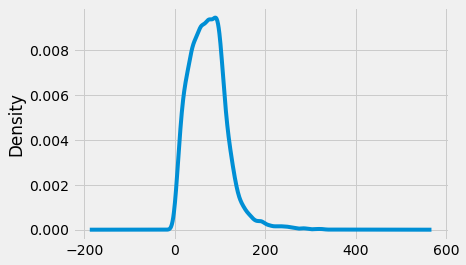

In [19]:
ytrain.plot.density()

In [20]:
#building final model and hyper-parameter tuning

In [21]:
params = {
        "objective" : "poisson",
    
        "metric" : "rmse",
        "learning_rate" : 0.075,
         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'verbosity': 1,
       'num_iterations' : 1000,        
        'num_leaves': 115,
        "min_data_in_leaf": 50,
}


m_lgb = lgb.train(params, dtrain, valid_sets = [dtrain, dvalid], 
                  early_stopping_rounds = 150,
                  verbose_eval=100)  

F:\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 17602, number of used features: 8
[LightGBM] [Info] Start training from score 4.303117
Training until validation scores don't improve for 150 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 32.1398	valid_1's rmse: 31.2162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [22]:
#dropping unuseful columns from test set to make predictions

df_test.drop(['wday','year', 'date'], axis = 1, inplace = True)

In [23]:
ypred = m_lgb.predict(df_test)

In [24]:
ypred

array([55.85719719, 52.92302351, 53.46489743, ..., 68.10040849,
       63.39169017, 61.2266034 ])

In [25]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

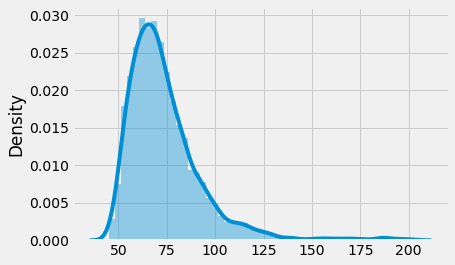

In [26]:
sns.distplot(ypred)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

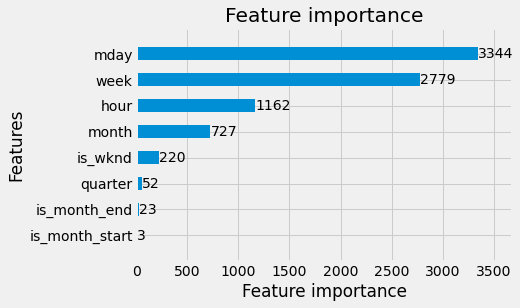

In [27]:
#feature importance

lgb.plot_importance(m_lgb,height = 0.5)

In [28]:
submission = pd.read_csv("C:/Users/HP/Desktop/av4/sample.csv")

In [29]:
#getting predictions for the target variable

submission.demand = ypred
submission.to_csv('C:/Users/HP/Desktop/av4/my_sub.csv', index=False)